<a href="https://colab.research.google.com/github/EsserMishelle/customer-spending-segmentation/blob/main/3_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering
## This notebook applies the finalized preprocessing and clustering parameters to assign customers to their respective segments.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

np.random.seed(42)

In [4]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/new_data1/refs/heads/main/Wholesale%20customers%20data.csv')
df_raw = df.copy() # for reference

## Data Preprocessing (for Clustering)

In [5]:
# Reusing spending variables identified during EDA
spend_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen' ]

X = df[spend_cols]

## Tranformation (Log)

Because spending data is heavily right-skewed with extreme values, a log1p transformation is applied to reduce the influence of very large expenditures before clustering.

In [6]:
X_log = np.log1p(X)

## Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X_log)

### PCA with chosen components

In [14]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

## Fit the Final Clustering
### K-Means with K=3 on 3 pca components


In [15]:
km = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init=10 to suppress future warnings
cluster_labels = km.fit_predict(X_pca)

df['Cluster'] = cluster_labels

## Final metrics

In [17]:
sil_score = silhouette_score(X_pca, cluster_labels)

print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: 0.33


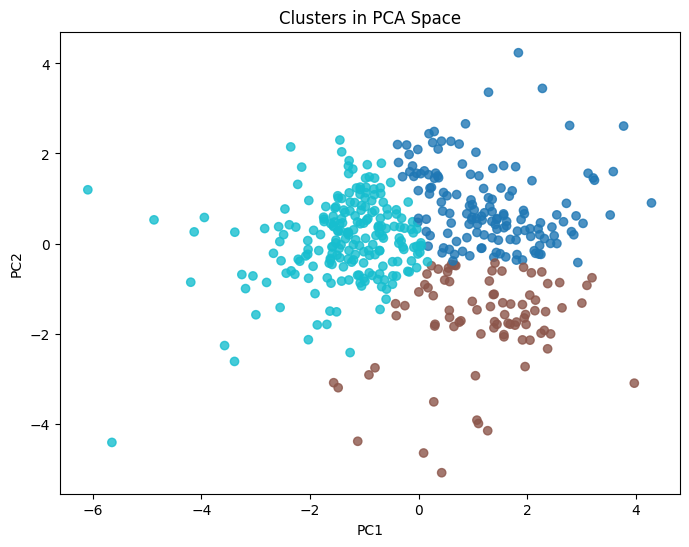

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', alpha=0.8)
plt.title("Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### PCA Cluster Visualization

The scatter plot shows customers projected onto the first two principal components, with points colored by their assigned K-Means cluster. The visualization indicates moderate separation among the three clusters in reduced-dimensional space, supporting the suitability of the selected clustering configuration.

**Cluster Sizes**

In [ ]:
df['Cluster'].value_counts().sort_index()

,count
Cluster,
0,145
1,83
2,212


##5. Cluster Profiling
###5.1 Cluster Profiles

In [ ]:
cluster_summary = df.groupby('Cluster')[spend_cols].mean()
cluster_summary


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,17182.386207,10658.075862,13380.979310,4181.110345,5003.641379,2867.220690
1,2966.927711,7010.903614,12397.277108,608.277108,5446.228916,795.000000
2,11992.594340,1995.429245,2496.915094,3277.839623,425.905660,892.504717


**Cluster Sizes**

In [ ]:
df['Cluster'].value_counts().sort_index()

,count
Cluster,
0,145
1,83
2,212


##5.2 Interpretation:

**Cluster 0 (Milk, Grocery, Detergent_Paper Buyers):**

Cluster 0 represents the smallest cluster. --volume of customers with disproportionately high Grocery, Milk, and Detergent_paper spending relative to their overall volume.-- Customers in this segment spend disproportionately high amounts on staple goods such as Grocery, Milk, and Detergents_Paper, indicating a focus on essential household or operational supplies rather than fresh or specialty products.

This pattern suggests consistent, necessity-driven purchasing behavior rather than broad or diversified consumption.

**Cluster 1 (High-Value Mix Lower_Volume General Buyers):**

Cluster 2 contains the largest number of customers with a lower average spending across all product categories. This pattern suggests smaller-scale or infrequent buyers with limited purchasing volume. These customers may engage in more selective or occasional purchasing rather than bulk or high-volume transactions.

**Custer 2 (High-Value-Overall Buyers):**

Cluster 1 represents the highest-spending customers across most product categories, with the exception of Detergent_Paper. This group exhibits high spending levels and a broad purchasing profile, indicating large-volume buyers with diverse needs.
These are customers that likely account for a substantial share of the store's revenue and represent strategically important accounts due to their high purchasing volume and category coverage.



In [ ]:
# Don't force labels - just present the data clearly
cluster_summary = df.groupby('Cluster')[spend_cols].mean()
cluster_sizes = df['Cluster'].value_counts().sort_index()

print("=== CLUSTER PROFILES ===\n")
for cluster in sorted(df['Cluster'].unique()):
    avg = cluster_summary.loc[cluster]
    size = cluster_sizes[cluster]

    print(f"Cluster {cluster} ({size} customers, {size/len(df)*100:.1f}%):")
    print(f"  Highest spending: {avg.idxmax()} (${avg.max():,.0f})")
    print(f"  Lowest spending: {avg.idxmin()} (${avg.min():,.0f})")
    print(f"  Total avg: ${avg.sum():,.0f}")
    print()

=== CLUSTER PROFILES ===

Cluster 0 (145 customers, 33.0%):
  Highest spending: Fresh ($17,182)
  Lowest spending: Delicassen ($2,867)
  Total avg: $53,273

Cluster 1 (83 customers, 18.9%):
  Highest spending: Grocery ($12,397)
  Lowest spending: Frozen ($608)
  Total avg: $29,225

Cluster 2 (212 customers, 48.2%):
  Highest spending: Fresh ($11,993)
  Lowest spending: Detergents_Paper ($426)
  Total avg: $21,081



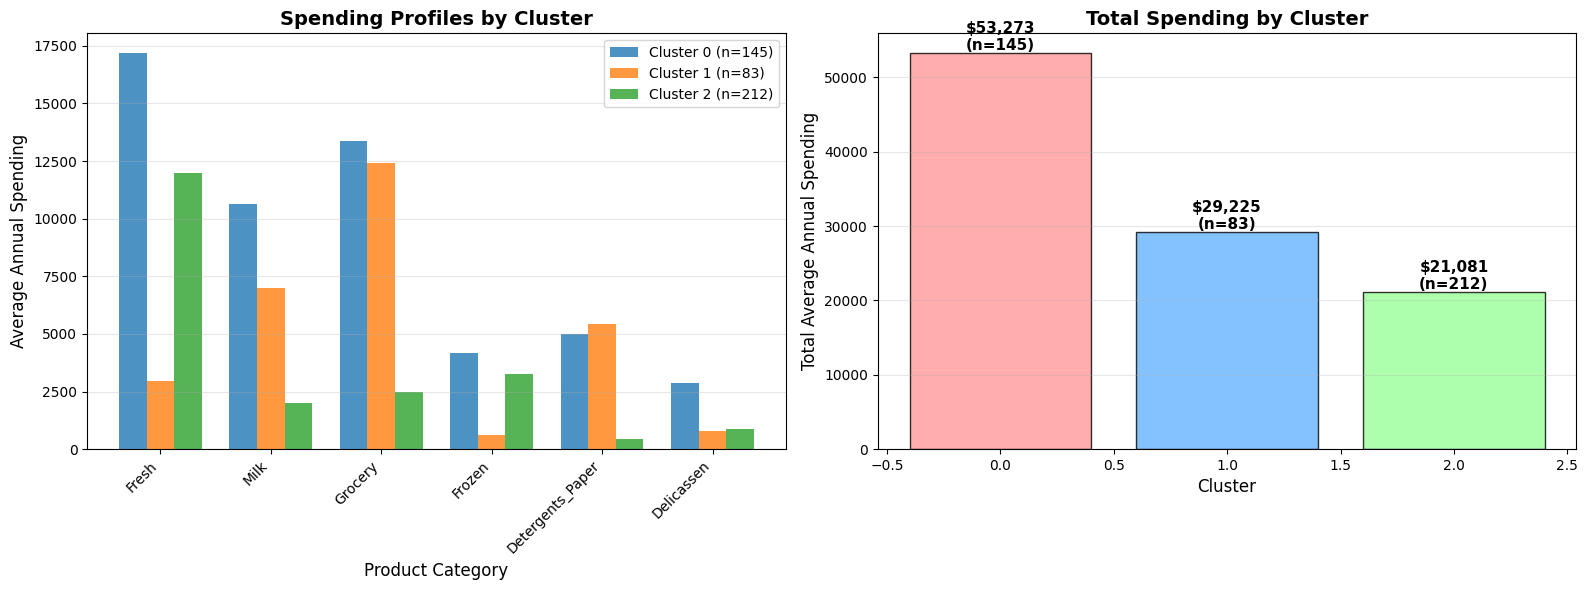


=== CLUSTER INTERPRETATION ===

Cluster 0 (145 customers, 33.0%):
  Total avg spending: $53,273
  Top 3 categories: Fresh, Grocery, Milk

Cluster 1 (83 customers, 18.9%):
  Total avg spending: $29,225
  Top 3 categories: Grocery, Milk, Detergents_Paper

Cluster 2 (212 customers, 48.2%):
  Total avg spending: $21,081
  Top 3 categories: Fresh, Frozen, Grocery


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages
cluster_summary = df.groupby('Cluster')[spend_cols].mean()
cluster_sizes = df['Cluster'].value_counts().sort_index()

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Spending by category
x = np.arange(len(spend_cols))
width = 0.25

for i, cluster in enumerate(cluster_summary.index):
    offset = width * (i - 1)
    ax1.bar(x + offset, cluster_summary.loc[cluster], width,
            label=f'Cluster {cluster} (n={cluster_sizes[cluster]})', alpha=0.8)

ax1.set_xlabel('Product Category', fontsize=12)
ax1.set_ylabel('Average Annual Spending', fontsize=12)
ax1.set_title('Spending Profiles by Cluster', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(spend_cols, rotation=45, ha='right')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Right: Total spending comparison
totals = cluster_summary.sum(axis=1)
colors = ['#ff9999', '#66b3ff', '#99ff99']
bars = ax2.bar(cluster_summary.index, totals, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, size in zip(bars, cluster_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}\n(n={size})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('Total Average Annual Spending', fontsize=12)
ax2.set_title('Total Spending by Cluster', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print clear interpretation
print("\n=== CLUSTER INTERPRETATION ===")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    avg_spend = cluster_data[spend_cols].mean()

    print(f"\nCluster {cluster} ({len(cluster_data)} customers, {len(cluster_data)/len(df)*100:.1f}%):")
    print(f"  Total avg spending: ${avg_spend.sum():,.0f}")
    print(f"  Top 3 categories: {', '.join(avg_spend.nlargest(3).index.tolist())}")

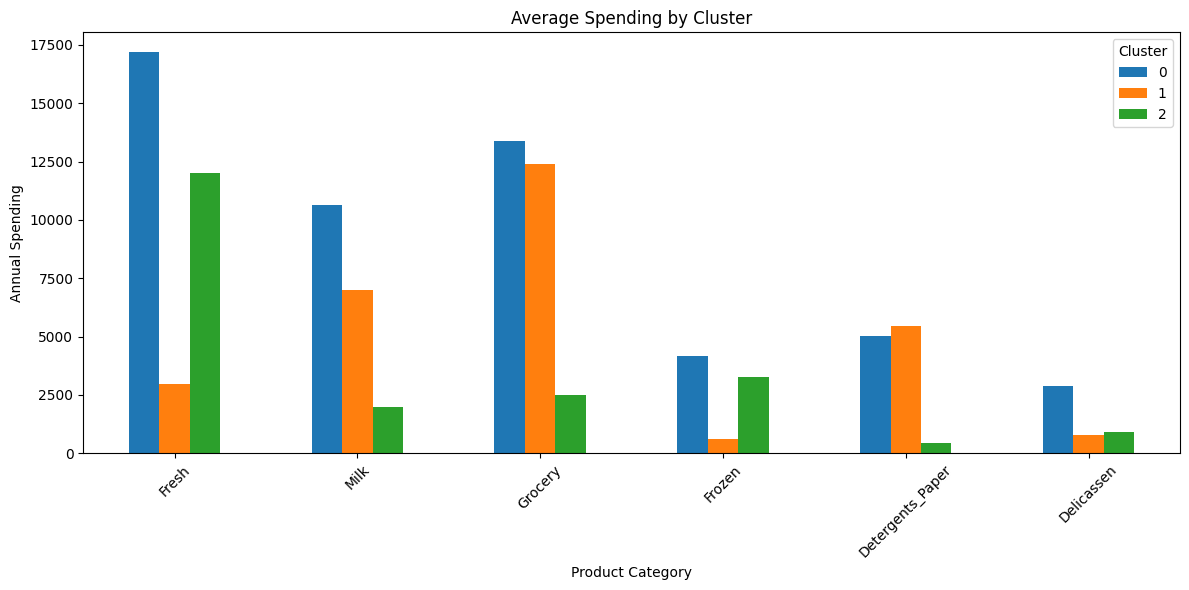

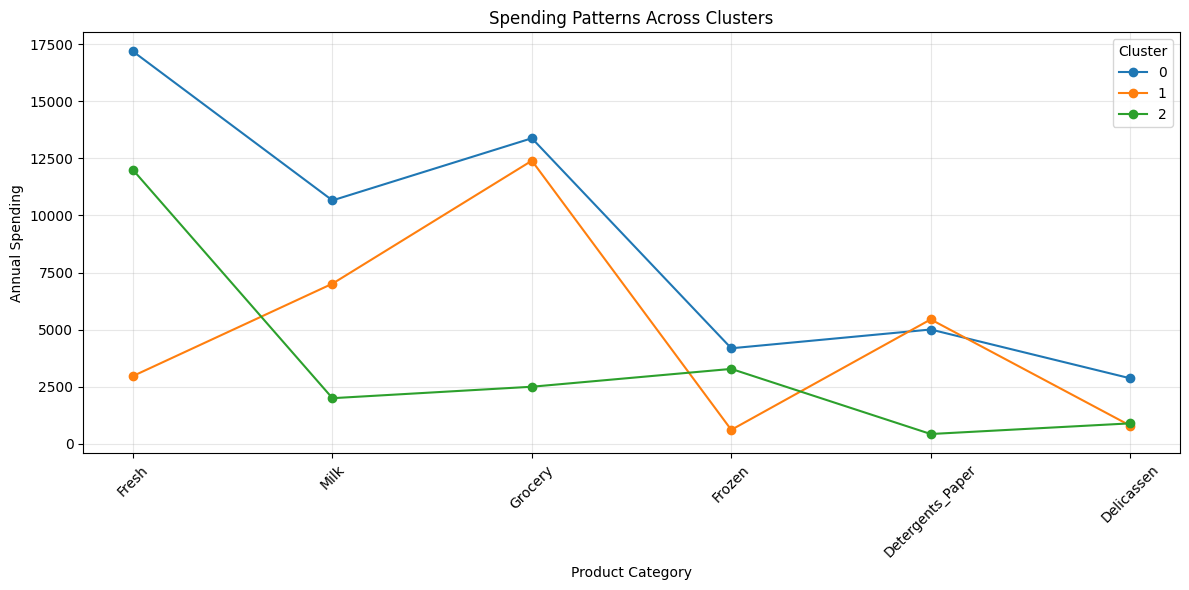

In [ ]:
# This is YOUR work - simple and effective
cluster_summary = df.groupby('Cluster')[spend_cols].mean()

# Simple grouped bar chart
cluster_summary.T.plot(kind='bar', figsize=(12, 6))
plt.title('Average Spending by Cluster')
plt.ylabel('Annual Spending')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Simple line plot (alternative view)
cluster_summary.T.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Spending Patterns Across Clusters')
plt.ylabel('Annual Spending')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##5.3 Business Implications

**Detergents_Paper and Grocery–focused buyers (Cluster 0)** may benefit from targeted promotions or bundled offerings aligned with their specialized purchasing behavior.

**High-Value-Overall Buyers (Cluster 1)** could be prioritized for retention strategies and account management due to their significant contribution to overall revenue.

**Lower-volume general buyers (Cluster 2)** represent an opportunity for growth through targeted outreach or cross-selling strategies.


##6. PCA Visualization (Supportive Analysis)

### PCA is used to visualize the cluster structure in two dimensions





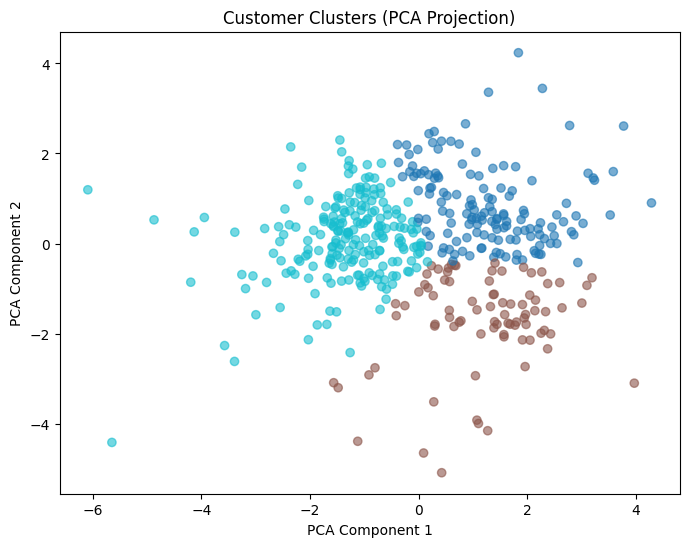

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df['Cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.title('Customer Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
pca.explained_variance_ratio_

array([0.44077752, 0.27194917])

* PCA is applied to display the clustered data in two dimensions for visualization purposes. The plot shows a clear grouping pattern corresponding to the tree clusters identified by K-Means, with some overlap resulting from dimensionality reduction.
* The first two principal components explain approximately 71% of the total variance, which is sufficient for visualizing overall cluster structure without influencing model selection.

- Clean and preprocess the data by handling missing values, applying any transformations if needed, and scaling features (some are 2 some are thousands) so no single variable dominates the clustering.


U cant use inertia to compare Kmeans and DBscan or Kmean sand hierachical clustering
j: inertia only works 4 Kmean. so u need sil score.  Assign each cust to a cluster and evaluate whether the resulting segments are stable and meaningfully separated.
- Profile each cluster using summary statistics and visualizations to understand how the segments differ from one another.


Try a bunch of clustering algorithms
- Apply one or more clustering algorithms (for example K-Means, hierarchical clustering, or DBSCAN) and choose model parameters using appropriate diagnostics and metrics.

- Assign each customer to a cluster and evaluate whether the resulting segments are stable and meaningfully separated.

Shrink down the demenions. For each cluster give me some statistics and visual to understand how each segments are diff from each other.

J: spend time get the code (the broken one) to get it to work.  the left chart

- Profile each cluster using summary statistics and visualizations to understand how the segments differ from one another.

- Describe each segment in plain language and propose at least one concrete business action or insight that could be taken based on the segmentation.